#### Results: Performance Summary

The final performance of the teacher, the independently trained student, and the distilled student on the CIFAR-100 test set are summarized below.

| Model                       | Top-1 Test Accuracy (%) | Top-5 Test Accuracy (%) |
| :-------------------------- | :---------------------- | :---------------------- |
| Teacher (VGG16-BN)          | 73.51%                  | 91.51%                  |
| Student (VGG11-BN, Indep.)  | 46.20%                  | 76.32%                  |
| **Student (VGG11-BN, KD)**  | **48.00%**              | **77.85%**              |

#### Discussion

Knowledge Distillation (KD) demonstrably improves the student model's performance compared to training it independently. The distilled student achieved a **Top-1 accuracy of 48.00%**, surpassing the independently trained student's **46.20%**. This improvement highlights the benefit of KD: the "dark knowledge" contained in the teacher's soft probability distribution provides a much richer and more informative training signal than the hard, one-hot encoded labels used in standard training. By learning to mimic the teacher's output distribution, the student learns not just to identify the correct class but also to understand the relative similarities between classes, which acts as a powerful regularizer and improves generalization.

The convergence behavior also differs significantly. As seen in the training curves, the KD student starts with a much higher baseline accuracy and consistently outperforms the independent student at every epoch. The learning curve for the KD student is steeper in the initial epochs, indicating a faster convergence towards a better solution. While the independent student struggles to learn meaningful features from scratch, the KD student is effectively guided by the teacher's pre-existing knowledge. This guidance helps the student navigate the complex loss landscape more efficiently, avoiding poor local minima and converging to a more robust and accurate final model. The smoother and more rapid progression of the KD student's validation accuracy underscores the stabilizing effect of using soft targets as a supervisory signal.

In [1]:
from train_eval import train, evaluate
from model import get_model
from data_utils import get_cifar100_loaders
import torch.nn as nn
import torch.optim as optim
import torch
train_loader, test_loader = get_cifar100_loaders(batch_size=128)
model = get_model('vgg11_bn', pretrained=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

(train_losses, train_top1, train_top5), (val_losses, val_top1, val_top5) = train(model, train_loader, test_loader, optimizer, criterion, epochs=20)
evaluate(model, test_loader, criterion)

torch.save(model.state_dict(), "vgg11_bn_finetuned.pth")
print("Model saved as vgg11_bn_finetuned.pth")


100%|██████████| 169M/169M [00:13<00:00, 12.4MB/s]
/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Eval Loss: 3.9391 | Top-1 Acc: 6.69% | Top-5 Acc: 26.27%
Epoch [1/20] | Train Loss: 4.3082 | Top-1: 2.95% | Top-5: 13.32% | Val Loss: 3.9391 | Top-1: 6.69% | Top-5: 26.27%
Eval Loss: 3.5324 | Top-1 Acc: 12.44% | Top-5 Acc: 39.82%
Epoch [2/20] | Train Loss: 3.8316 | Top-1: 8.10% | Top-5: 29.12% | Val Loss: 3.5324 | Top-1: 12.44% | Top-5: 39.82%
Eval Loss: 3.2522 | Top-1 Acc: 18.02% | Top-5 Acc: 48.07%
Epoch [3/20] | Train Loss: 3.4916 | Top-1: 12.84% | Top-5: 40.12% | Val Loss: 3.2522 | Top-1: 18.02% | Top-5: 48.07%
Eval Loss: 3.0796 | Top-1 Acc: 21.25% | Top-5 Acc: 52.27%
Epoch [4/20] | Train Loss: 3.2592 | Top-1: 17.24% | Top-5: 47.29% | Val Loss: 3.0796 | Top-1: 21.25% | Top-5: 52.27%
Eval Loss: 2.8480 | Top-1 Acc: 25.13% | Top-5 Acc: 58.39%
Epoch [5/20] | Train Loss: 3.0765 | Top-1: 20.72% | Top-5: 52.66% | Val Loss: 2.8480 | Top-1: 25.13% | Top-5: 58.39%
Eval Loss: 2

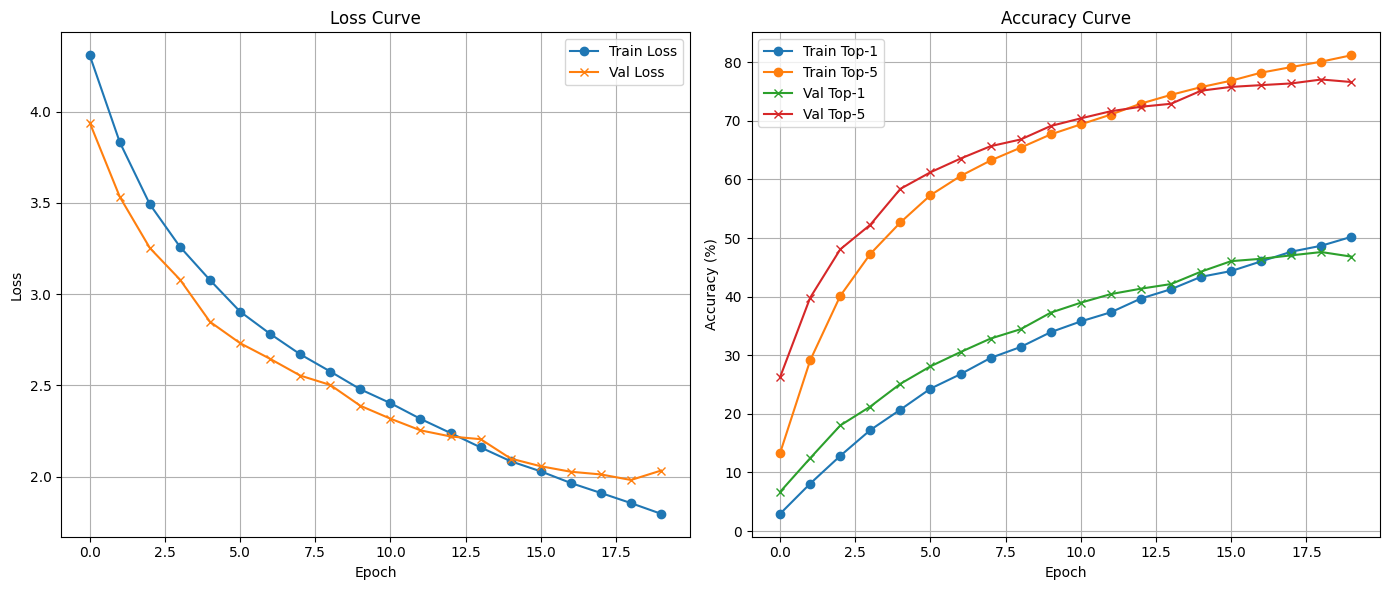

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))

# Loss curve
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.grid(True)
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(train_top1, label='Train Top-1', marker='o')
plt.plot(train_top5, label='Train Top-5', marker='o')
plt.plot(val_top1, label='Val Top-1', marker='x')
plt.plot(val_top5, label='Val Top-5', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
from data_utils import get_cifar100_loaders
from model import get_model
from train_eval import evaluate
from train_kd import train_kd, KDLoss
import torch
import torch.nn as nn
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_loader, test_loader = get_cifar100_loaders(batch_size=128, num_workers=2)

teacher = get_model('vgg16_bn', pretrained=True, num_classes=100)
student = get_model('vgg11_bn', pretrained=False, num_classes=100)

teacher.to(device)
student.to(device)

ce_criterion = nn.CrossEntropyLoss()
kd_criterion = KDLoss(ce_criterion, alpha=0.6, T=3.0)
optimizer = optim.Adam(student.parameters(), lr=1e-4)

student, epoch_losses, epoch_ce, epoch_kd, epoch_top1, epoch_top5, val_losses, val_ce_losses, val_kd_losses, val_top1, val_top5 = train_kd(student=student,
                   teacher=teacher,
                   train_loader=train_loader,
                   val_loader=test_loader,
                   optimizer=optimizer,
                   kd_criterion=kd_criterion,
                   epochs=20,
                   device=device,
                   save_path='student_kd_final.pth',
                   log_every=20)

avg_loss, top1, top5 = evaluate(student, test_loader, ce_criterion, device=device)
print(f"Test -> Loss: {avg_loss:.4f}, Top1: {top1:.2f}%, Top5: {top5:.2f}%")

torch.save(student.state_dict(), "distilled_student.pth")
print("Distilled Student Saved")


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Epoch 1 Batch 20/391 | Loss 16.0504 (CE 4.6027, KD 23.6822) | Top1 1.37% Top5 5.98%
Epoch 1 Batch 40/391 | Loss 16.1139 (CE 4.5985, KD 23.7908) | Top1 1.31% Top5 6.09%
Epoch 1 Batch 60/391 | Loss 16.1254 (CE 4.5852, KD 23.8188) | Top1 1.12% Top5 6.48%
Epoch 1 Batch 80/391 | Loss 16.0586 (CE 4.5758, KD 23.7138) | Top1 1.26% Top5 6.82%
Epoch 1 Batch 100/391 | Loss 15.9968 (CE 4.5669, KD 23.6168) | Top1 1.36% Top5 7.09%
Epoch 1 Batch 120/391 | Loss 15.9702 (CE 4.5564, KD 23.5794) | Top1 1.46% Top5 7.46%
Epoch 1 Batch 140/391 | Loss 15.9143 (CE 4.5424, KD 23.4956) | Top1 1.46% Top5 7.56%
Epoch 1 Batch 160/391 | Loss 15.8508 (CE 4.5284, KD 23.3990) | Top1 1.50% Top5 7.84%
Epoch 1 Batch 180/391 | Loss 15.7851 (CE 4.5138, KD 23.2993) | Top1 1.60% Top5 8.15%
Epoch 1 Batch 200/391 | Loss 15.7437 (CE 4.5053, KD 23.2359) | Top1 1.66% Top5 8.32%
Epoch 1 Batch 220/391 | Loss 15.6866 (CE 4.4906, KD 23.1505) | Top1 1.76% Top5 8.65%
Epoch 1 Batch 240/391 | Loss 15.6335 (CE 4.4773, KD 23.0710) | Top1 1

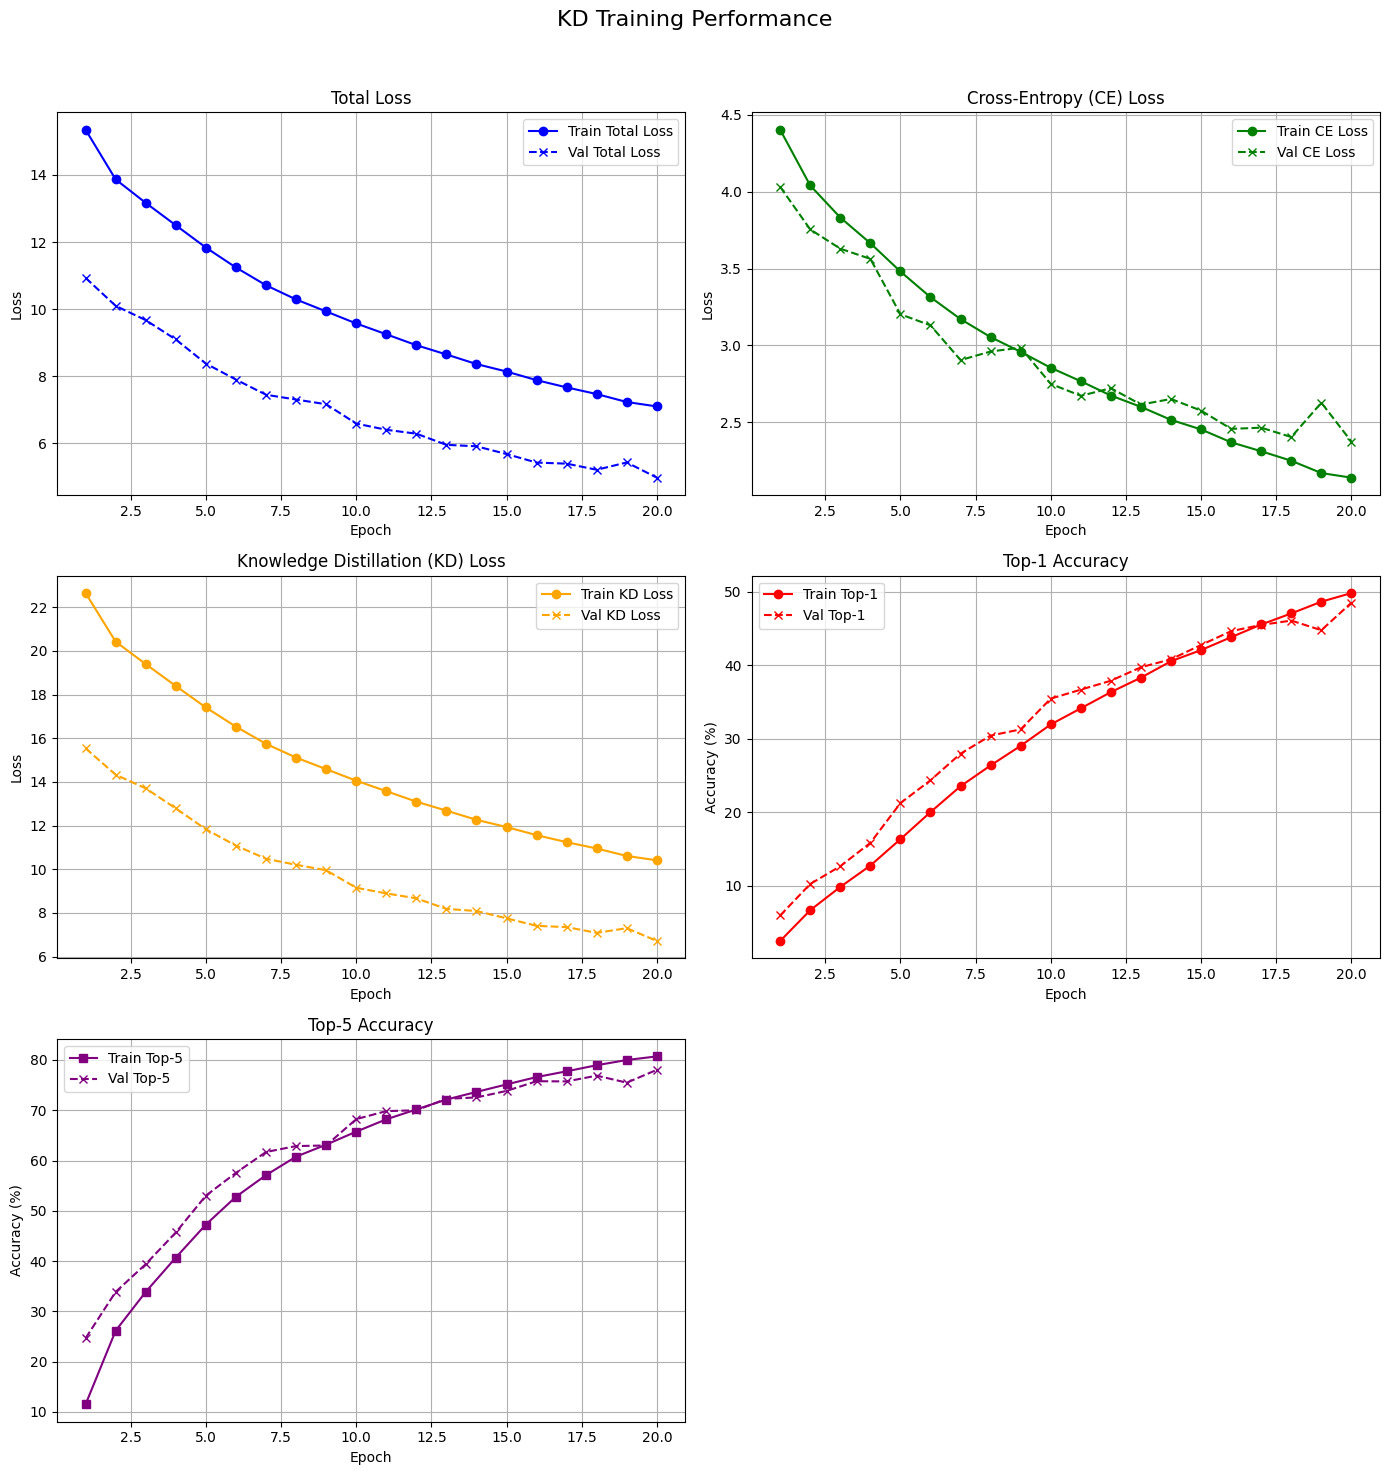

In [7]:
import matplotlib.pyplot as plt
import numpy as np

epochs = 20
epoch_range = range(1, epochs + 1)

fig, axes = plt.subplots(3, 2, figsize=(14, 15))
fig.suptitle('KD Training Performance', fontsize=16)
axes = axes.flatten()

# --- Plot 1: Total Loss ---
axes[0].plot(epoch_range, epoch_losses, label='Train Total Loss', color='blue', marker='o')
axes[0].plot(epoch_range, val_losses, label='Val Total Loss', color='blue', marker='x', linestyle='--')
axes[0].set_title('Total Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()

# --- Plot 2: Cross-Entropy (CE) Loss ---
axes[1].plot(epoch_range, epoch_ce, label='Train CE Loss', color='green', marker='o')
axes[1].plot(epoch_range, val_ce_losses, label='Val CE Loss', color='green', marker='x', linestyle='--')
axes[1].set_title('Cross-Entropy (CE) Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].grid(True)
axes[1].legend()

# --- Plot 3: Knowledge Distillation (KD) Loss ---
axes[2].plot(epoch_range, epoch_kd, label='Train KD Loss', color='orange', marker='o')
axes[2].plot(epoch_range, val_kd_losses, label='Val KD Loss', color='orange', marker='x', linestyle='--')
axes[2].set_title('Knowledge Distillation (KD) Loss')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].grid(True)
axes[2].legend()

# --- Plot 4: Top-1 Accuracy ---
axes[3].plot(epoch_range, epoch_top1, label='Train Top-1', color='red', marker='o')
axes[3].plot(epoch_range, val_top1, label='Val Top-1', color='red', marker='x', linestyle='--')
axes[3].set_title('Top-1 Accuracy')
axes[3].set_xlabel('Epoch')
axes[3].set_ylabel('Accuracy (%)')
axes[3].grid(True)
axes[3].legend()

# --- Plot 5: Top-5 Accuracy ---
axes[4].plot(epoch_range, epoch_top5, label='Train Top-5', color='purple', marker='s')
axes[4].plot(epoch_range, val_top5, label='Val Top-5', color='purple', marker='x', linestyle='--')
axes[4].set_title('Top-5 Accuracy')
axes[4].set_xlabel('Epoch')
axes[4].set_ylabel('Accuracy (%)')
axes[4].grid(True)
axes[4].legend()

# Remove empty subplot
fig.delaxes(axes[5])
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()